In [70]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import auc,roc_curve

from sklearn.externals import joblib
import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler,SMOTE

from random import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

nrow = 80000
number_of_time = 10

In [7]:
train = pd.read_csv('../data/train.csv',nrows=nrow)
train.drop('ID_code',inplace= True,axis=1)

In [251]:
reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
            22,24,25,26,27,41,29,
            32,35,37,40,48,49,47,
            55,51,52,53,60,61,62,103,65,66,67,69,
            70,71,74,78,79,
            82,84,89,90,91,94,95,96,97,99,
            105,106,110,111,112,118,119,125,128,
            130,133,134,135,137,138,
            140,144,145,147,151,155,157,159,
            161,162,163,164,167,168,
            170,171,173,175,176,179,
            180,181,184,185,187,189,
            190,191,195,196,199]
reverse_list = ['var_%d'%i for i in reverse_list]
def features_engineer(x):
    res_x = x.copy()
#    res_x = pd.DataFrame(MinMaxScaler(feature_range=(0,100)).fit_transform(x.copy()),columns=x.columns)
#    for col in res_x.columns:
#        if col in reverse_list:
#            res_x[col] = res_x[col] * (-1)
#    res_x['g2'] = res_x['var_3'] + res_x['var_154']
    res_x['g1'] = res_x['var_0'] + res_x['var_2'] + res_x['var_6']
    res_x['g2'] = res_x['var_1'] + res_x['var_5'] + res_x['var_15'] + res_x['var_40']+\
    res_x['var_94']
#    res_x['g3'] = res_x['var_4'] + res_x['var_35'] + res_x['var_173'] + res_x['var_188']
#    res_x['g5'] = res_x['var_11'] + res_x['var_155']
#    res_x['g7'] = res_x['var_19'] + res_x['var_135'] + res_x['var_166']
#    res_x['g12'] = res_x['var_50'] + res_x['var_148'] + res_x['var_165']
#    res_x['g14'] = res_x['var_56'] + res_x['var_63']
#    res_x['g16'] = res_x['var_64'] + res_x['var_175']
#    res_x['g21'] = res_x['var_93'] + res_x['var_179']

    return(res_x)

In [9]:
def data_augmentation(x,y,low_class_ratio = 0.2,method = 'none'):
    if method == 'random_under_sample':
        sm = RandomUnderSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'random_over_sample':
        sm = RandomOverSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'smote':
        sm = SMOTE(sampling_strategy=1-low_class_ratio,m_neighbors=10,kind='svm')
        aug_x,aug_y = sm.fit_resample(x,y)
#    elif method == 'shuffle':
        
    else:
        aug_x = x
        aug_y = y
    
    return(pd.DataFrame(aug_x,columns=x.columns),pd.DataFrame(aug_y,columns=['target']))

In [10]:
#test = pd.read_csv('../data/test.csv')
#sub = pd.DataFrame()
#sub['ID_code'] = test['ID_code']
#test.drop('ID_code',axis=1,inplace=True)
train,test = train_test_split(train,test_size = 0.3)

In [ ]:
train_x = train.drop('target',axis=1).reset_index(drop=True)
train_y = pd.DataFrame(train['target']).reset_index(drop=True)
test_x = test.drop('target',axis=1)

In [252]:
fe_train_x = features_engineer(train_x)
fe_test_x = features_engineer(test_x)

In [12]:
#predict and combine
def models_list_predict(models,test_x):
    res = np.zeros((test.shape[0]))
    for model in models:
        res = res + model.predict(test_x)
    res = res/len(models)
    return(res)

def combine_pred(x,y,test_x):
    pred = np.zeros((test.shape[0]))
    for i in range(number_of_time):
        model = k_fold_train(x,y,'none',random()/2)
        pred = pred + model.predict(test_x)

    pred = pred/number_of_time
    return(pred)

In [51]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.2,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.003,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial',
    "verbosity" : 1,
    "bagging_seed" : 15,
    "seed": 15
}

param_tune = {
    'bagging_freq': 5,
    'bagging_fraction': 0.5,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.003,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial',
    "verbosity" : 1,
    "bagging_seed" : 15,
    "seed": 15
}

def k_fold_train(x,y,model_param = param,sample_method = 'none'):
    kf = StratifiedKFold(n_splits=3,shuffle=True)
    models = []
    for train_index,val_index in kf.split(x,y):
        train_model_x,val_model_x = x.iloc[train_index,:],x.iloc[val_index,:]
        train_model_y,val_model_y = y.iloc[train_index],y.iloc[val_index]
        n_x,n_y = data_augmentation(train_model_x,train_model_y,method=sample_method,low_class_ratio=random()/2+0.1)
        train_data = lgb.Dataset(n_x,n_y)
        val_data = lgb.Dataset(val_model_x,val_model_y)
        
        model = lgb.train(model_param,train_set=train_data,num_boost_round=100000,verbose_eval = 100,
                          early_stopping_rounds=1000,valid_sets = [train_data,val_data])
        models.append(model)
    return(models)

In [14]:
base_line = k_fold_train(train_x,train_y)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.867301	valid_1's auc: 0.826571
[200]	training's auc: 0.899868	valid_1's auc: 0.856999
[300]	training's auc: 0.909897	valid_1's auc: 0.866622
[400]	training's auc: 0.914988	valid_1's auc: 0.872501
[500]	training's auc: 0.916897	valid_1's auc: 0.874991
[600]	training's auc: 0.919496	valid_1's auc: 0.877225
[700]	training's auc: 0.921234	valid_1's auc: 0.878181
[800]	training's auc: 0.922738	valid_1's auc: 0.880764
[900]	training's auc: 0.924578	valid_1's auc: 0.881516
[1000]	training's auc: 0.92525	valid_1's auc: 0.882751
[1100]	training's auc: 0.926339	valid_1's auc: 0.883168
[1200]	training's auc: 0.926803	valid_1's auc: 0.883635
[1300]	training's auc: 0.927829	valid_1's auc: 0.884032
[1400]	training's auc: 0.92884	valid_1's auc: 0.884719
[1500]	training's auc: 0.929595	valid_1's auc: 0.885719
[1600]	training's auc: 0.929496	valid_1's auc: 0.886069
[1700]	training's auc: 0.930074	valid_1's auc: 0.88

[14700]	training's auc: 0.97314	valid_1's auc: 0.895009
[14800]	training's auc: 0.973322	valid_1's auc: 0.894885
Early stopping, best iteration is:
[13867]	training's auc: 0.971295	valid_1's auc: 0.895208
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.872271	valid_1's auc: 0.810482
[200]	training's auc: 0.902739	valid_1's auc: 0.847823
[300]	training's auc: 0.9135	valid_1's auc: 0.86144
[400]	training's auc: 0.918303	valid_1's auc: 0.867814
[500]	training's auc: 0.921205	valid_1's auc: 0.871317
[600]	training's auc: 0.923299	valid_1's auc: 0.87333
[700]	training's auc: 0.924811	valid_1's auc: 0.874535
[800]	training's auc: 0.925413	valid_1's auc: 0.876013
[900]	training's auc: 0.926297	valid_1's auc: 0.877406
[1000]	training's auc: 0.927407	valid_1's auc: 0.87801
[1100]	training's auc: 0.928511	valid_1's auc: 0.879172
[1200]	training's auc: 0.928884	valid_1's auc: 0.879892
[1300]	training's auc: 0.929234	valid_1's auc: 0.880179
[1400]	training's

[6700]	training's auc: 0.955953	valid_1's auc: 0.878745
[6800]	training's auc: 0.956284	valid_1's auc: 0.87886
[6900]	training's auc: 0.956544	valid_1's auc: 0.878887
[7000]	training's auc: 0.95682	valid_1's auc: 0.878822
[7100]	training's auc: 0.95709	valid_1's auc: 0.878852
[7200]	training's auc: 0.957374	valid_1's auc: 0.878977
[7300]	training's auc: 0.957653	valid_1's auc: 0.878999
[7400]	training's auc: 0.95795	valid_1's auc: 0.878997
[7500]	training's auc: 0.958226	valid_1's auc: 0.879063
[7600]	training's auc: 0.958558	valid_1's auc: 0.879143
[7700]	training's auc: 0.958868	valid_1's auc: 0.879056
[7800]	training's auc: 0.959141	valid_1's auc: 0.878883
[7900]	training's auc: 0.959457	valid_1's auc: 0.878881
[8000]	training's auc: 0.959776	valid_1's auc: 0.878859
[8100]	training's auc: 0.960101	valid_1's auc: 0.878809
[8200]	training's auc: 0.960372	valid_1's auc: 0.8789
[8300]	training's auc: 0.960598	valid_1's auc: 0.878914
[8400]	training's auc: 0.960916	valid_1's auc: 0.87891

In [253]:
fe_test = k_fold_train(fe_train_x,train_y)
#random_under = k_fold_train(train_x,train_y,'random_under_sample')

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.87483	valid_1's auc: 0.819715
[200]	training's auc: 0.90192	valid_1's auc: 0.849686
[300]	training's auc: 0.907679	valid_1's auc: 0.855747
[400]	training's auc: 0.913205	valid_1's auc: 0.86218
[500]	training's auc: 0.918255	valid_1's auc: 0.866395
[600]	training's auc: 0.919491	valid_1's auc: 0.86687
[700]	training's auc: 0.921999	valid_1's auc: 0.871104
[800]	training's auc: 0.923357	valid_1's auc: 0.872429
[900]	training's auc: 0.924026	valid_1's auc: 0.87374
[1000]	training's auc: 0.924911	valid_1's auc: 0.874676
[1100]	training's auc: 0.92515	valid_1's auc: 0.874288
[1200]	training's auc: 0.926273	valid_1's auc: 0.87616
[1300]	training's auc: 0.926897	valid_1's auc: 0.877159
[1400]	training's auc: 0.927906	valid_1's auc: 0.877767
[1500]	training's auc: 0.928437	valid_1's auc: 0.878617
[1600]	training's auc: 0.929021	valid_1's auc: 0.879295
[1700]	training's auc: 0.929351	valid_1's auc: 0.879544


[2800]	training's auc: 0.935973	valid_1's auc: 0.882557
[2900]	training's auc: 0.936406	valid_1's auc: 0.883013
[3000]	training's auc: 0.937052	valid_1's auc: 0.883471
[3100]	training's auc: 0.937417	valid_1's auc: 0.883563
[3200]	training's auc: 0.937896	valid_1's auc: 0.883687
[3300]	training's auc: 0.938457	valid_1's auc: 0.883517
[3400]	training's auc: 0.938904	valid_1's auc: 0.883701
[3500]	training's auc: 0.939317	valid_1's auc: 0.883895
[3600]	training's auc: 0.939744	valid_1's auc: 0.884135
[3700]	training's auc: 0.939964	valid_1's auc: 0.884139
[3800]	training's auc: 0.940353	valid_1's auc: 0.884305
[3900]	training's auc: 0.940636	valid_1's auc: 0.884509
[4000]	training's auc: 0.94106	valid_1's auc: 0.884621
[4100]	training's auc: 0.941569	valid_1's auc: 0.884819
[4200]	training's auc: 0.941989	valid_1's auc: 0.884903
[4300]	training's auc: 0.942441	valid_1's auc: 0.885088
[4400]	training's auc: 0.942934	valid_1's auc: 0.885162
[4500]	training's auc: 0.943357	valid_1's auc: 0.

[5700]	training's auc: 0.949936	valid_1's auc: 0.881333
[5800]	training's auc: 0.950236	valid_1's auc: 0.881378
[5900]	training's auc: 0.9506	valid_1's auc: 0.881425
[6000]	training's auc: 0.950915	valid_1's auc: 0.881605
[6100]	training's auc: 0.951256	valid_1's auc: 0.881641
[6200]	training's auc: 0.951641	valid_1's auc: 0.881796
[6300]	training's auc: 0.952003	valid_1's auc: 0.882013
[6400]	training's auc: 0.952291	valid_1's auc: 0.881961
[6500]	training's auc: 0.952722	valid_1's auc: 0.882119
[6600]	training's auc: 0.953061	valid_1's auc: 0.882151
[6700]	training's auc: 0.953415	valid_1's auc: 0.882121
[6800]	training's auc: 0.953757	valid_1's auc: 0.882171
[6900]	training's auc: 0.954092	valid_1's auc: 0.882162
[7000]	training's auc: 0.95436	valid_1's auc: 0.88221
[7100]	training's auc: 0.954794	valid_1's auc: 0.88231
[7200]	training's auc: 0.95512	valid_1's auc: 0.882428
[7300]	training's auc: 0.955385	valid_1's auc: 0.882566
[7400]	training's auc: 0.95569	valid_1's auc: 0.882576

In [183]:
#random_over = k_fold_train(train_x,train_y,'random_over_sample')

In [184]:
#smote = k_fold_train(train_x,train_y,'smote')

In [18]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [19]:
pred = models_list_predict(base_line,test_x)

result_df = pd.DataFrame()
result_df['label'] = test['target']
result_df['base'] = pred

In [254]:
#pred = random_under.predict(test.drop('target',axis=1))
#result_df['random_under'] = pred

pred = models_list_predict(fe_test,fe_test_x)
result_df['feature_test'] = pred

#pred = models_list_predict(smote,test.drop('target',axis=1))
#result_df['smote'] = pred

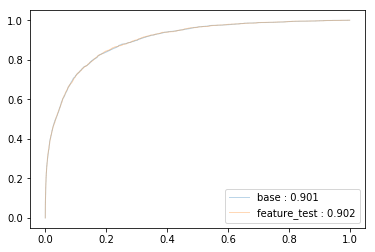

,models,auc_score
0,base,0.901364
1,feature_test,0.901722


In [255]:
plotGraph(result_df)

In [11]:
#final_pred = combine_pred(x,y,test)
final_pred = models_list_predict(base_line,test)

In [12]:
sub['target'] = final_pred
sub.to_csv("../data/models_list_pred_base.csv",index=False)

In [206]:
fe_train_x.var_15.describe()

count    56000.000000
mean        14.571463
std          0.411392
min         13.076900
25%         14.261400
50%         14.574150
75%         14.871900
max         15.713200
Name: var_15, dtype: float64

In [248]:
train_x.var_94.describe()

count    56000.000000
mean        11.002865
std          2.763523
min          3.478600
25%          8.836750
50%         10.985600
75%         13.101350
max         18.651700
Name: var_94, dtype: float64

In [249]:
fe_train_x['g'] = fe_train_x['var_1'] + fe_train_x['var_5'] + fe_train_x['var_15'] + fe_train_x['var_40']+\
    fe_train_x['var_94']

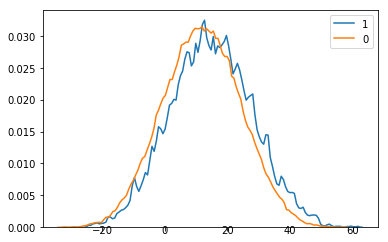

In [250]:
f = 'g'
data_1 = fe_train_x[train_y.target == 1]
data_0 = fe_train_x[train_y.target == 0]
sns.kdeplot(data_1[f], bw=0.5,label='1')
sns.kdeplot(data_0[f], bw=0.5,label='0')
locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.show()

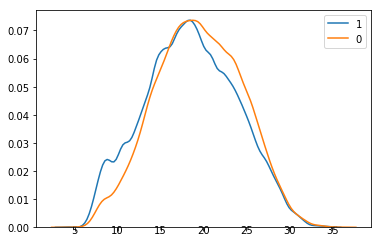

In [234]:
f = 'var_165'
data_1 = fe_train_x[train_y.target == 1]
data_0 = fe_train_x[train_y.target == 0]
sns.kdeplot(data_1[f], bw=0.5,label='1')
sns.kdeplot(data_0[f], bw=0.5,label='0')
locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.show()

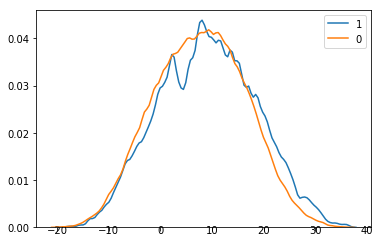

In [228]:
f = 'g'
data_1 = fe_train_x[train_y.target == 1]
data_0 = fe_train_x[train_y.target == 0]
sns.kdeplot(data_1[f], bw=0.5,label='1')
sns.kdeplot(data_0[f], bw=0.5,label='0')
locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.show()